## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
#!mkdir ./data
#!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
#!unzip -n ./data/train-test-data.zip -d ./data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
#from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=136, out_features=136, bias=True)
)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=136, out_features=136, bias=True)
)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                        RandomCrop(224),
                                        Normalize(),
                                        ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/paul/git/facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [8]:
# load training data in batches
batch_size = 1

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [9]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [10]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [28]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor) #int64 to train, FloatTensor to test

        # forward pass to get net output
        net.to("cpu")
        output_pts = net(images.to("cpu"))
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [29]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fa6fceca5f8>>
Traceback (most recent call last):
  File "/home/paul/anaconda3/envs/my_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paul/anaconda3/envs/my_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paul/anaconda3/envs/my_env/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paul/anaconda3/envs/my_env/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paul/anaconda3/envs/my_env/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/paul/anaconda3/envs/my_env/

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [30]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

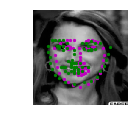

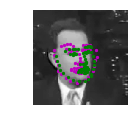

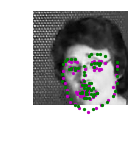

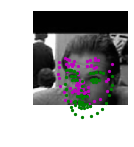

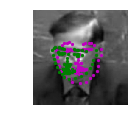

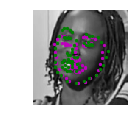

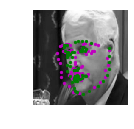

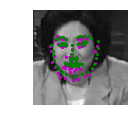

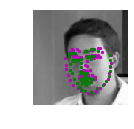

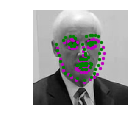

In [31]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [20]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("starting epoch "+str(epoch))
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print("starting batch "+str(batch_i))
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images.to(device))

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts.to(device))

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                
            #if batch_i == 500:
            #    break

    print('Finished Training')


In [21]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
train_net(n_epochs)

starting epoch 0
Epoch: 1, Batch: 10, Avg. Loss: 0.39985878616571424
Epoch: 1, Batch: 20, Avg. Loss: 0.4613791912794113
Epoch: 1, Batch: 30, Avg. Loss: 0.22481957972049713
Epoch: 1, Batch: 40, Avg. Loss: 0.18037131950259208
Epoch: 1, Batch: 50, Avg. Loss: 0.2508686035871506
Epoch: 1, Batch: 60, Avg. Loss: 0.19397476091980934
Epoch: 1, Batch: 70, Avg. Loss: 0.26963225156068804
Epoch: 1, Batch: 80, Avg. Loss: 0.17908801212906839
Epoch: 1, Batch: 90, Avg. Loss: 0.2284902885556221
Epoch: 1, Batch: 100, Avg. Loss: 0.1690590087324381
Epoch: 1, Batch: 110, Avg. Loss: 0.14535598903894426
Epoch: 1, Batch: 120, Avg. Loss: 0.14594732001423835
Epoch: 1, Batch: 130, Avg. Loss: 0.17201465368270874
Epoch: 1, Batch: 140, Avg. Loss: 0.0689081683754921
Epoch: 1, Batch: 150, Avg. Loss: 0.12813503630459308
Epoch: 1, Batch: 160, Avg. Loss: 0.10291972421109677
Epoch: 1, Batch: 170, Avg. Loss: 0.10142841748893261
Epoch: 1, Batch: 180, Avg. Loss: 0.10712937377393246
Epoch: 1, Batch: 190, Avg. Loss: 0.11080945

Epoch: 1, Batch: 1550, Avg. Loss: 0.10172416400164366
Epoch: 1, Batch: 1560, Avg. Loss: 0.11541057843714952
Epoch: 1, Batch: 1570, Avg. Loss: 0.11835943907499313
Epoch: 1, Batch: 1580, Avg. Loss: 0.14164463002234698
Epoch: 1, Batch: 1590, Avg. Loss: 0.1048097426071763
Epoch: 1, Batch: 1600, Avg. Loss: 0.12846605628728866
Epoch: 1, Batch: 1610, Avg. Loss: 0.13863617917522789
Epoch: 1, Batch: 1620, Avg. Loss: 0.13191055059432982
Epoch: 1, Batch: 1630, Avg. Loss: 0.11145880743861199
Epoch: 1, Batch: 1640, Avg. Loss: 0.08381515014916659
Epoch: 1, Batch: 1650, Avg. Loss: 0.2137561533600092
Epoch: 1, Batch: 1660, Avg. Loss: 0.1603495476767421
Epoch: 1, Batch: 1670, Avg. Loss: 0.06991609446704387
Epoch: 1, Batch: 1680, Avg. Loss: 0.11617525182664394
Epoch: 1, Batch: 1690, Avg. Loss: 0.09257960505783558
Epoch: 1, Batch: 1700, Avg. Loss: 0.11977428607642651
Epoch: 1, Batch: 1710, Avg. Loss: 0.17133262511342764
Epoch: 1, Batch: 1720, Avg. Loss: 0.11292419843375683
Epoch: 1, Batch: 1730, Avg. Los

Epoch: 1, Batch: 3100, Avg. Loss: 0.13918206617236137
Epoch: 1, Batch: 3110, Avg. Loss: 0.09866139683872462
Epoch: 1, Batch: 3120, Avg. Loss: 0.0901560615748167
Epoch: 1, Batch: 3130, Avg. Loss: 0.13209553323686124
Epoch: 1, Batch: 3140, Avg. Loss: 0.07929224148392677
Epoch: 1, Batch: 3150, Avg. Loss: 0.09055323852226138
Epoch: 1, Batch: 3160, Avg. Loss: 0.10695450976490975
Epoch: 1, Batch: 3170, Avg. Loss: 0.12527870796620846
Epoch: 1, Batch: 3180, Avg. Loss: 0.08835669383406639
Epoch: 1, Batch: 3190, Avg. Loss: 0.08781563621014357
Epoch: 1, Batch: 3200, Avg. Loss: 0.145551585778594
Epoch: 1, Batch: 3210, Avg. Loss: 0.09885039636865259
Epoch: 1, Batch: 3220, Avg. Loss: 0.12604990396648647
Epoch: 1, Batch: 3230, Avg. Loss: 0.1955257650464773
Epoch: 1, Batch: 3240, Avg. Loss: 0.10594017524272203
Epoch: 1, Batch: 3250, Avg. Loss: 0.14294444266706705
Epoch: 1, Batch: 3260, Avg. Loss: 0.10274398494511842
Epoch: 1, Batch: 3270, Avg. Loss: 0.07888024803251029
Epoch: 1, Batch: 3280, Avg. Loss

Epoch: 2, Batch: 1200, Avg. Loss: 0.10438576070591807
Epoch: 2, Batch: 1210, Avg. Loss: 0.12623055316507817
Epoch: 2, Batch: 1220, Avg. Loss: 0.11200586035847664
Epoch: 2, Batch: 1230, Avg. Loss: 0.10529367392882705
Epoch: 2, Batch: 1240, Avg. Loss: 0.11604235181584954
Epoch: 2, Batch: 1250, Avg. Loss: 0.09327457519248128
Epoch: 2, Batch: 1260, Avg. Loss: 0.13368064370006322
Epoch: 2, Batch: 1270, Avg. Loss: 0.19951356146484614
Epoch: 2, Batch: 1280, Avg. Loss: 0.12094348557293415
Epoch: 2, Batch: 1290, Avg. Loss: 0.12324030632153153
Epoch: 2, Batch: 1300, Avg. Loss: 0.20618032943457365
Epoch: 2, Batch: 1310, Avg. Loss: 0.07014274187386035
Epoch: 2, Batch: 1320, Avg. Loss: 0.10530301630496978
Epoch: 2, Batch: 1330, Avg. Loss: 0.0912906588986516
Epoch: 2, Batch: 1340, Avg. Loss: 0.09294518083333969
Epoch: 2, Batch: 1350, Avg. Loss: 0.09462416395545006
Epoch: 2, Batch: 1360, Avg. Loss: 0.1314897332340479
Epoch: 2, Batch: 1370, Avg. Loss: 0.07774148248136044
Epoch: 2, Batch: 1380, Avg. Lo

Epoch: 2, Batch: 2730, Avg. Loss: 0.06848200266249478
Epoch: 2, Batch: 2740, Avg. Loss: 0.09740312304347754
Epoch: 2, Batch: 2750, Avg. Loss: 0.08370734564960003
Epoch: 2, Batch: 2760, Avg. Loss: 0.08337375558912755
Epoch: 2, Batch: 2770, Avg. Loss: 0.09222255386412144
Epoch: 2, Batch: 2780, Avg. Loss: 0.06492973025888205
Epoch: 2, Batch: 2790, Avg. Loss: 0.10083787515759468
Epoch: 2, Batch: 2800, Avg. Loss: 0.1561339883133769
Epoch: 2, Batch: 2810, Avg. Loss: 0.11245974125340581
Epoch: 2, Batch: 2820, Avg. Loss: 0.11785793956369162
Epoch: 2, Batch: 2830, Avg. Loss: 0.08005058877170086
Epoch: 2, Batch: 2840, Avg. Loss: 0.12683101147413253
Epoch: 2, Batch: 2850, Avg. Loss: 0.1319381756708026
Epoch: 2, Batch: 2860, Avg. Loss: 0.08319622185081244
Epoch: 2, Batch: 2870, Avg. Loss: 0.08283908972516656
Epoch: 2, Batch: 2880, Avg. Loss: 0.07400833573192359
Epoch: 2, Batch: 2890, Avg. Loss: 0.14120153225958348
Epoch: 2, Batch: 2900, Avg. Loss: 0.1788439156487584
Epoch: 2, Batch: 2910, Avg. Los

Epoch: 3, Batch: 810, Avg. Loss: 0.07466285349801183
Epoch: 3, Batch: 820, Avg. Loss: 0.12405379023402929
Epoch: 3, Batch: 830, Avg. Loss: 0.06255005309358239
Epoch: 3, Batch: 840, Avg. Loss: 0.08430572533980012
Epoch: 3, Batch: 850, Avg. Loss: 0.07923088110983371
Epoch: 3, Batch: 860, Avg. Loss: 0.10403853300958872
Epoch: 3, Batch: 870, Avg. Loss: 0.08333394043147564
Epoch: 3, Batch: 880, Avg. Loss: 0.09512314684689045
Epoch: 3, Batch: 890, Avg. Loss: 0.12966329976916313
Epoch: 3, Batch: 900, Avg. Loss: 0.10157877188175916
Epoch: 3, Batch: 910, Avg. Loss: 0.13406253065913915
Epoch: 3, Batch: 920, Avg. Loss: 0.13532827123999597
Epoch: 3, Batch: 930, Avg. Loss: 0.0890410610474646
Epoch: 3, Batch: 940, Avg. Loss: 0.1081564768217504
Epoch: 3, Batch: 950, Avg. Loss: 0.08894360419362783
Epoch: 3, Batch: 960, Avg. Loss: 0.0627468639984727
Epoch: 3, Batch: 970, Avg. Loss: 0.111850442038849
Epoch: 3, Batch: 980, Avg. Loss: 0.08881962448358535
Epoch: 3, Batch: 990, Avg. Loss: 0.0620627464726567

Epoch: 3, Batch: 2350, Avg. Loss: 0.0898474657908082
Epoch: 3, Batch: 2360, Avg. Loss: 0.10312936324626207
Epoch: 3, Batch: 2370, Avg. Loss: 0.19185355566442014
Epoch: 3, Batch: 2380, Avg. Loss: 0.10092916917055846
Epoch: 3, Batch: 2390, Avg. Loss: 0.10419610124081373
Epoch: 3, Batch: 2400, Avg. Loss: 0.09195157960057258
Epoch: 3, Batch: 2410, Avg. Loss: 0.06555920159444213
Epoch: 3, Batch: 2420, Avg. Loss: 0.0694731437601149
Epoch: 3, Batch: 2430, Avg. Loss: 0.08002222273498774
Epoch: 3, Batch: 2440, Avg. Loss: 0.1278541781939566
Epoch: 3, Batch: 2450, Avg. Loss: 0.06740107825025916
Epoch: 3, Batch: 2460, Avg. Loss: 0.141002444550395
Epoch: 3, Batch: 2470, Avg. Loss: 0.046818849118426445
Epoch: 3, Batch: 2480, Avg. Loss: 0.06446906393393874
Epoch: 3, Batch: 2490, Avg. Loss: 0.10892775170505047
Epoch: 3, Batch: 2500, Avg. Loss: 0.14645625818520785
Epoch: 3, Batch: 2510, Avg. Loss: 0.0517013501143083
Epoch: 3, Batch: 2520, Avg. Loss: 0.1340101346373558
Epoch: 3, Batch: 2530, Avg. Loss: 

Epoch: 4, Batch: 420, Avg. Loss: 0.06860745269805194
Epoch: 4, Batch: 430, Avg. Loss: 0.23793385606259107
Epoch: 4, Batch: 440, Avg. Loss: 0.1551027599722147
Epoch: 4, Batch: 450, Avg. Loss: 0.088112748041749
Epoch: 4, Batch: 460, Avg. Loss: 0.11817646920680999
Epoch: 4, Batch: 470, Avg. Loss: 0.13174668997526168
Epoch: 4, Batch: 480, Avg. Loss: 0.14194188490509987
Epoch: 4, Batch: 490, Avg. Loss: 0.16553178373724223
Epoch: 4, Batch: 500, Avg. Loss: 0.061241110786795616
Epoch: 4, Batch: 510, Avg. Loss: 0.0698221585713327
Epoch: 4, Batch: 520, Avg. Loss: 0.12204655539244413
Epoch: 4, Batch: 530, Avg. Loss: 0.08292171377688647
Epoch: 4, Batch: 540, Avg. Loss: 0.1414183683693409
Epoch: 4, Batch: 550, Avg. Loss: 0.14465401973575354
Epoch: 4, Batch: 560, Avg. Loss: 0.11071283193305134
Epoch: 4, Batch: 570, Avg. Loss: 0.2302573101595044
Epoch: 4, Batch: 580, Avg. Loss: 0.12544298451393843
Epoch: 4, Batch: 590, Avg. Loss: 0.22323461128398775
Epoch: 4, Batch: 600, Avg. Loss: 0.1162091452628374

Epoch: 4, Batch: 1980, Avg. Loss: 0.13795622158795595
Epoch: 4, Batch: 1990, Avg. Loss: 0.06933198980987072
Epoch: 4, Batch: 2000, Avg. Loss: 0.08101808717474342
Epoch: 4, Batch: 2010, Avg. Loss: 0.09583417009562253
Epoch: 4, Batch: 2020, Avg. Loss: 0.19434815987478943
Epoch: 4, Batch: 2030, Avg. Loss: 0.11309879347681999
Epoch: 4, Batch: 2040, Avg. Loss: 0.10810761619359255
Epoch: 4, Batch: 2050, Avg. Loss: 0.11454523503780364
Epoch: 4, Batch: 2060, Avg. Loss: 0.13138295551761986
Epoch: 4, Batch: 2070, Avg. Loss: 0.03592683891765773
Epoch: 4, Batch: 2080, Avg. Loss: 0.09075769465416669
Epoch: 4, Batch: 2090, Avg. Loss: 0.10351148303598165
Epoch: 4, Batch: 2100, Avg. Loss: 0.07816479727625847
Epoch: 4, Batch: 2110, Avg. Loss: 0.0906132474541664
Epoch: 4, Batch: 2120, Avg. Loss: 0.06816826658323408
Epoch: 4, Batch: 2130, Avg. Loss: 0.09918751707300544
Epoch: 4, Batch: 2140, Avg. Loss: 0.13685825495049359
Epoch: 4, Batch: 2150, Avg. Loss: 0.09390442054718733
Epoch: 4, Batch: 2160, Avg. L

Epoch: 5, Batch: 60, Avg. Loss: 0.0682846425101161
Epoch: 5, Batch: 70, Avg. Loss: 0.1179964642971754
Epoch: 5, Batch: 80, Avg. Loss: 0.15578923113644122
Epoch: 5, Batch: 90, Avg. Loss: 0.1333444368094206
Epoch: 5, Batch: 100, Avg. Loss: 0.07916058031842113
Epoch: 5, Batch: 110, Avg. Loss: 0.06211233492940664
Epoch: 5, Batch: 120, Avg. Loss: 0.09292052229866385
Epoch: 5, Batch: 130, Avg. Loss: 0.1100539343431592
Epoch: 5, Batch: 140, Avg. Loss: 0.05004428140819073
Epoch: 5, Batch: 150, Avg. Loss: 0.18073652153834702
Epoch: 5, Batch: 160, Avg. Loss: 0.12117133494466543
Epoch: 5, Batch: 170, Avg. Loss: 0.1225307397544384
Epoch: 5, Batch: 180, Avg. Loss: 0.11605757642537355
Epoch: 5, Batch: 190, Avg. Loss: 0.103595557436347
Epoch: 5, Batch: 200, Avg. Loss: 0.11179263601079584
Epoch: 5, Batch: 210, Avg. Loss: 0.12693298384547233
Epoch: 5, Batch: 220, Avg. Loss: 0.055786552652716634
Epoch: 5, Batch: 230, Avg. Loss: 0.14246681611984968
Epoch: 5, Batch: 240, Avg. Loss: 0.09744388228282333
Epo

Epoch: 5, Batch: 1630, Avg. Loss: 0.11972050424665212
Epoch: 5, Batch: 1640, Avg. Loss: 0.07497076503932476
Epoch: 5, Batch: 1650, Avg. Loss: 0.14912394089624287
Epoch: 5, Batch: 1660, Avg. Loss: 0.1057853190228343
Epoch: 5, Batch: 1670, Avg. Loss: 0.09039950873702765
Epoch: 5, Batch: 1680, Avg. Loss: 0.1114412073045969
Epoch: 5, Batch: 1690, Avg. Loss: 0.05235469397157431
Epoch: 5, Batch: 1700, Avg. Loss: 0.09682264886796474
Epoch: 5, Batch: 1710, Avg. Loss: 0.09676375407725572
Epoch: 5, Batch: 1720, Avg. Loss: 0.11260098852217197
Epoch: 5, Batch: 1730, Avg. Loss: 0.09521207381039858
Epoch: 5, Batch: 1740, Avg. Loss: 0.0656581224873662
Epoch: 5, Batch: 1750, Avg. Loss: 0.1255042301490903
Epoch: 5, Batch: 1760, Avg. Loss: 0.1011824956163764
Epoch: 5, Batch: 1770, Avg. Loss: 0.14999437406659127
Epoch: 5, Batch: 1780, Avg. Loss: 0.1690257809124887
Epoch: 5, Batch: 1790, Avg. Loss: 0.12281857896596193
Epoch: 5, Batch: 1800, Avg. Loss: 0.17367921769618988
Epoch: 5, Batch: 1810, Avg. Loss: 

Epoch: 5, Batch: 3170, Avg. Loss: 0.12664321046322585
Epoch: 5, Batch: 3180, Avg. Loss: 0.0671676114667207
Epoch: 5, Batch: 3190, Avg. Loss: 0.059838983975350854
Epoch: 5, Batch: 3200, Avg. Loss: 0.06829033363610507
Epoch: 5, Batch: 3210, Avg. Loss: 0.07271692040376365
Epoch: 5, Batch: 3220, Avg. Loss: 0.10353754125535489
Epoch: 5, Batch: 3230, Avg. Loss: 0.11614842750132084
Epoch: 5, Batch: 3240, Avg. Loss: 0.06800875719636679
Epoch: 5, Batch: 3250, Avg. Loss: 0.08752411575987935
Epoch: 5, Batch: 3260, Avg. Loss: 0.08916928553953767
Epoch: 5, Batch: 3270, Avg. Loss: 0.05776959685608744
Epoch: 5, Batch: 3280, Avg. Loss: 0.05795404836535454
Epoch: 5, Batch: 3290, Avg. Loss: 0.12465442717075348
Epoch: 5, Batch: 3300, Avg. Loss: 0.08849883759394288
Epoch: 5, Batch: 3310, Avg. Loss: 0.11697966158390045
Epoch: 5, Batch: 3320, Avg. Loss: 0.0860622501000762
Epoch: 5, Batch: 3330, Avg. Loss: 0.17037703301757573
Epoch: 5, Batch: 3340, Avg. Loss: 0.13679636986926197
Epoch: 5, Batch: 3350, Avg. L

Epoch: 6, Batch: 1250, Avg. Loss: 0.06499056546017527
Epoch: 6, Batch: 1260, Avg. Loss: 0.09678758885711432
Epoch: 6, Batch: 1270, Avg. Loss: 0.05837505105882883
Epoch: 6, Batch: 1280, Avg. Loss: 0.06375141944736243
Epoch: 6, Batch: 1290, Avg. Loss: 0.0719561630859971
Epoch: 6, Batch: 1300, Avg. Loss: 0.07530195880681276
Epoch: 6, Batch: 1310, Avg. Loss: 0.08372322041541339
Epoch: 6, Batch: 1320, Avg. Loss: 0.03807048602029681
Epoch: 6, Batch: 1330, Avg. Loss: 0.06229809867218137
Epoch: 6, Batch: 1340, Avg. Loss: 0.07098656119778753
Epoch: 6, Batch: 1350, Avg. Loss: 0.10076464610174299
Epoch: 6, Batch: 1360, Avg. Loss: 0.04437147276476026
Epoch: 6, Batch: 1370, Avg. Loss: 0.11533937442582101
Epoch: 6, Batch: 1380, Avg. Loss: 0.10142640192061662
Epoch: 6, Batch: 1390, Avg. Loss: 0.07000442333519459
Epoch: 6, Batch: 1400, Avg. Loss: 0.056709189899265766
Epoch: 6, Batch: 1410, Avg. Loss: 0.11610836572945119
Epoch: 6, Batch: 1420, Avg. Loss: 0.07149483375251293
Epoch: 6, Batch: 1430, Avg. 

Epoch: 6, Batch: 2780, Avg. Loss: 0.13093328550457956
Epoch: 6, Batch: 2790, Avg. Loss: 0.12576830610632897
Epoch: 6, Batch: 2800, Avg. Loss: 0.04888725774362683
Epoch: 6, Batch: 2810, Avg. Loss: 0.054635693319141865
Epoch: 6, Batch: 2820, Avg. Loss: 0.03517842288129032
Epoch: 6, Batch: 2830, Avg. Loss: 0.042313132993876935
Epoch: 6, Batch: 2840, Avg. Loss: 0.11248580999672413
Epoch: 6, Batch: 2850, Avg. Loss: 0.08755859471857548
Epoch: 6, Batch: 2860, Avg. Loss: 0.06693979687988758
Epoch: 6, Batch: 2870, Avg. Loss: 0.03869555103592574
Epoch: 6, Batch: 2880, Avg. Loss: 0.13573046084493398
Epoch: 6, Batch: 2890, Avg. Loss: 0.10400305259972811
Epoch: 6, Batch: 2900, Avg. Loss: 0.05800466444343329
Epoch: 6, Batch: 2910, Avg. Loss: 0.11822511423379183
Epoch: 6, Batch: 2920, Avg. Loss: 0.10914571397006512
Epoch: 6, Batch: 2930, Avg. Loss: 0.041133792605251074
Epoch: 6, Batch: 2940, Avg. Loss: 0.06542632430791855
Epoch: 6, Batch: 2950, Avg. Loss: 0.0817411882802844
Epoch: 6, Batch: 2960, Avg

Epoch: 7, Batch: 880, Avg. Loss: 0.06473615756258369
Epoch: 7, Batch: 890, Avg. Loss: 0.056488952785730365
Epoch: 7, Batch: 900, Avg. Loss: 0.09841874563135207
Epoch: 7, Batch: 910, Avg. Loss: 0.06590374102815985
Epoch: 7, Batch: 920, Avg. Loss: 0.08388269245624543
Epoch: 7, Batch: 930, Avg. Loss: 0.06542605441063643
Epoch: 7, Batch: 940, Avg. Loss: 0.07256863052025438
Epoch: 7, Batch: 950, Avg. Loss: 0.0873295589350164
Epoch: 7, Batch: 960, Avg. Loss: 0.05568784731440246
Epoch: 7, Batch: 970, Avg. Loss: 0.043127006059512495
Epoch: 7, Batch: 980, Avg. Loss: 0.08464219174347817
Epoch: 7, Batch: 990, Avg. Loss: 0.06337005272507668
Epoch: 7, Batch: 1000, Avg. Loss: 0.09747354667633772
Epoch: 7, Batch: 1010, Avg. Loss: 0.0942159416154027
Epoch: 7, Batch: 1020, Avg. Loss: 0.12281689662486314
Epoch: 7, Batch: 1030, Avg. Loss: 0.07032679580152035
Epoch: 7, Batch: 1040, Avg. Loss: 0.07536934437230229
Epoch: 7, Batch: 1050, Avg. Loss: 0.06106774276122451
Epoch: 7, Batch: 1060, Avg. Loss: 0.0764

Epoch: 7, Batch: 2410, Avg. Loss: 0.0969484125263989
Epoch: 7, Batch: 2420, Avg. Loss: 0.04635298773646355
Epoch: 7, Batch: 2430, Avg. Loss: 0.08759015295654535
Epoch: 7, Batch: 2440, Avg. Loss: 0.07258948283270002
Epoch: 7, Batch: 2450, Avg. Loss: 0.048396086506545546
Epoch: 7, Batch: 2460, Avg. Loss: 0.04938676413148642
Epoch: 7, Batch: 2470, Avg. Loss: 0.03558712494559586
Epoch: 7, Batch: 2480, Avg. Loss: 0.08432745262980461
Epoch: 7, Batch: 2490, Avg. Loss: 0.06726563535630703
Epoch: 7, Batch: 2500, Avg. Loss: 0.04227634761482477
Epoch: 7, Batch: 2510, Avg. Loss: 0.13432367686182262
Epoch: 7, Batch: 2520, Avg. Loss: 0.046107929199934006
Epoch: 7, Batch: 2530, Avg. Loss: 0.09932878422550857
Epoch: 7, Batch: 2540, Avg. Loss: 0.05518242195248604
Epoch: 7, Batch: 2550, Avg. Loss: 0.0698151702992618
Epoch: 7, Batch: 2560, Avg. Loss: 0.06218509376049042
Epoch: 7, Batch: 2570, Avg. Loss: 0.04845166392624378
Epoch: 7, Batch: 2580, Avg. Loss: 0.049359444389119746
Epoch: 7, Batch: 2590, Avg.

Epoch: 8, Batch: 480, Avg. Loss: 0.10030414015054703
Epoch: 8, Batch: 490, Avg. Loss: 0.04761151536367834
Epoch: 8, Batch: 500, Avg. Loss: 0.15207319017499685
Epoch: 8, Batch: 510, Avg. Loss: 0.09599047480151057
Epoch: 8, Batch: 520, Avg. Loss: 0.042415252421051264
Epoch: 8, Batch: 530, Avg. Loss: 0.06375902346335352
Epoch: 8, Batch: 540, Avg. Loss: 0.09940191004425288
Epoch: 8, Batch: 550, Avg. Loss: 0.04927767056506127
Epoch: 8, Batch: 560, Avg. Loss: 0.03205153192393482
Epoch: 8, Batch: 570, Avg. Loss: 0.05763123761862517
Epoch: 8, Batch: 580, Avg. Loss: 0.06592729771509767
Epoch: 8, Batch: 590, Avg. Loss: 0.05647032931447029
Epoch: 8, Batch: 600, Avg. Loss: 0.07814916777424515
Epoch: 8, Batch: 610, Avg. Loss: 0.06406416678801179
Epoch: 8, Batch: 620, Avg. Loss: 0.11490672323852777
Epoch: 8, Batch: 630, Avg. Loss: 0.05503716692328453
Epoch: 8, Batch: 640, Avg. Loss: 0.06148844677954912
Epoch: 8, Batch: 650, Avg. Loss: 0.06136110732331872
Epoch: 8, Batch: 660, Avg. Loss: 0.0281498638

Epoch: 8, Batch: 2010, Avg. Loss: 0.03944042762741447
Epoch: 8, Batch: 2020, Avg. Loss: 0.043221086636185645
Epoch: 8, Batch: 2030, Avg. Loss: 0.03588301753625274
Epoch: 8, Batch: 2040, Avg. Loss: 0.04108078507706523
Epoch: 8, Batch: 2050, Avg. Loss: 0.055615005735307935
Epoch: 8, Batch: 2060, Avg. Loss: 0.03626001281663775
Epoch: 8, Batch: 2070, Avg. Loss: 0.059015529975295064
Epoch: 8, Batch: 2080, Avg. Loss: 0.051599602494388816
Epoch: 8, Batch: 2090, Avg. Loss: 0.041927633062005046
Epoch: 8, Batch: 2100, Avg. Loss: 0.026063201809301974
Epoch: 8, Batch: 2110, Avg. Loss: 0.04537751311436296
Epoch: 8, Batch: 2120, Avg. Loss: 0.06063497206196189
Epoch: 8, Batch: 2130, Avg. Loss: 0.06880678031593561
Epoch: 8, Batch: 2140, Avg. Loss: 0.027872380055487155
Epoch: 8, Batch: 2150, Avg. Loss: 0.050151870818808675
Epoch: 8, Batch: 2160, Avg. Loss: 0.04629508480429649
Epoch: 8, Batch: 2170, Avg. Loss: 0.06476257534231991
Epoch: 8, Batch: 2180, Avg. Loss: 0.07880122512578965
Epoch: 8, Batch: 219

Epoch: 9, Batch: 60, Avg. Loss: 0.04226724810432643
Epoch: 9, Batch: 70, Avg. Loss: 0.09538926305249333
Epoch: 9, Batch: 80, Avg. Loss: 0.03078023074194789
Epoch: 9, Batch: 90, Avg. Loss: 0.02698463893029839
Epoch: 9, Batch: 100, Avg. Loss: 0.043525716220028696
Epoch: 9, Batch: 110, Avg. Loss: 0.03790200999937952
Epoch: 9, Batch: 120, Avg. Loss: 0.03777795471251011
Epoch: 9, Batch: 130, Avg. Loss: 0.04531508013606071
Epoch: 9, Batch: 140, Avg. Loss: 0.022601387277245522
Epoch: 9, Batch: 150, Avg. Loss: 0.03178819306194782
Epoch: 9, Batch: 160, Avg. Loss: 0.0326118566095829
Epoch: 9, Batch: 170, Avg. Loss: 0.06971916127949954
Epoch: 9, Batch: 180, Avg. Loss: 0.05521027566865087
Epoch: 9, Batch: 190, Avg. Loss: 0.04799012243747711
Epoch: 9, Batch: 200, Avg. Loss: 0.035898957308381794
Epoch: 9, Batch: 210, Avg. Loss: 0.038242101296782495
Epoch: 9, Batch: 220, Avg. Loss: 0.03061788631603122
Epoch: 9, Batch: 230, Avg. Loss: 0.027741758991032837
Epoch: 9, Batch: 240, Avg. Loss: 0.03016514196

Epoch: 9, Batch: 1600, Avg. Loss: 0.03466897318139672
Epoch: 9, Batch: 1610, Avg. Loss: 0.02396312658675015
Epoch: 9, Batch: 1620, Avg. Loss: 0.02069151299074292
Epoch: 9, Batch: 1630, Avg. Loss: 0.02877006637863815
Epoch: 9, Batch: 1640, Avg. Loss: 0.061483954451978205
Epoch: 9, Batch: 1650, Avg. Loss: 0.1173603548668325
Epoch: 9, Batch: 1660, Avg. Loss: 0.026531647145748138
Epoch: 9, Batch: 1670, Avg. Loss: 0.03159966641105712
Epoch: 9, Batch: 1680, Avg. Loss: 0.02606104505248368
Epoch: 9, Batch: 1690, Avg. Loss: 0.018583324551582337
Epoch: 9, Batch: 1700, Avg. Loss: 0.08167830687016249
Epoch: 9, Batch: 1710, Avg. Loss: 0.09499141108244658
Epoch: 9, Batch: 1720, Avg. Loss: 0.06678013468626887
Epoch: 9, Batch: 1730, Avg. Loss: 0.05606703162193298
Epoch: 9, Batch: 1740, Avg. Loss: 0.07783238082192838
Epoch: 9, Batch: 1750, Avg. Loss: 0.16489370102062822
Epoch: 9, Batch: 1760, Avg. Loss: 0.029944480769336222
Epoch: 9, Batch: 1770, Avg. Loss: 0.14418337475508453
Epoch: 9, Batch: 1780, Av

Epoch: 9, Batch: 3150, Avg. Loss: 0.07512137219309807
Epoch: 9, Batch: 3160, Avg. Loss: 0.0474153452552855
Epoch: 9, Batch: 3170, Avg. Loss: 0.0754932607524097
Epoch: 9, Batch: 3180, Avg. Loss: 0.038895224779844285
Epoch: 9, Batch: 3190, Avg. Loss: 0.0402874025516212
Epoch: 9, Batch: 3200, Avg. Loss: 0.017120562400668858
Epoch: 9, Batch: 3210, Avg. Loss: 0.05312825506553054
Epoch: 9, Batch: 3220, Avg. Loss: 0.0329833603464067
Epoch: 9, Batch: 3230, Avg. Loss: 0.021670625917613505
Epoch: 9, Batch: 3240, Avg. Loss: 0.05547506799921394
Epoch: 9, Batch: 3250, Avg. Loss: 0.02793187778443098
Epoch: 9, Batch: 3260, Avg. Loss: 0.07624669289216399
Epoch: 9, Batch: 3270, Avg. Loss: 0.035414003767073154
Epoch: 9, Batch: 3280, Avg. Loss: 0.06223216811195016
Epoch: 9, Batch: 3290, Avg. Loss: 0.02936647171154618
Epoch: 9, Batch: 3300, Avg. Loss: 0.06735015772283078
Epoch: 9, Batch: 3310, Avg. Loss: 0.036934133525937794
Epoch: 9, Batch: 3320, Avg. Loss: 0.04413180612027645
Epoch: 9, Batch: 3330, Avg.

Epoch: 10, Batch: 1230, Avg. Loss: 0.0315584902651608
Epoch: 10, Batch: 1240, Avg. Loss: 0.014424557238817215
Epoch: 10, Batch: 1250, Avg. Loss: 0.02396176685579121
Epoch: 10, Batch: 1260, Avg. Loss: 0.032577387150377037
Epoch: 10, Batch: 1270, Avg. Loss: 0.054367008293047546
Epoch: 10, Batch: 1280, Avg. Loss: 0.06396901244297623
Epoch: 10, Batch: 1290, Avg. Loss: 0.03065845356322825
Epoch: 10, Batch: 1300, Avg. Loss: 0.03280687644146383
Epoch: 10, Batch: 1310, Avg. Loss: 0.17255296893417835
Epoch: 10, Batch: 1320, Avg. Loss: 0.04317567236721516
Epoch: 10, Batch: 1330, Avg. Loss: 0.1186415902338922
Epoch: 10, Batch: 1340, Avg. Loss: 0.022839380428195
Epoch: 10, Batch: 1350, Avg. Loss: 0.03364024506881833
Epoch: 10, Batch: 1360, Avg. Loss: 0.06907182675786316
Epoch: 10, Batch: 1370, Avg. Loss: 0.021513267722912132
Epoch: 10, Batch: 1380, Avg. Loss: 0.04846522570587695
Epoch: 10, Batch: 1390, Avg. Loss: 0.029509658529423177
Epoch: 10, Batch: 1400, Avg. Loss: 0.053442247305065395
Epoch: 1

Epoch: 10, Batch: 2710, Avg. Loss: 0.043167390301823615
Epoch: 10, Batch: 2720, Avg. Loss: 0.027961683087050916
Epoch: 10, Batch: 2730, Avg. Loss: 0.013562694797292352
Epoch: 10, Batch: 2740, Avg. Loss: 0.05071161924861371
Epoch: 10, Batch: 2750, Avg. Loss: 0.023151042219251395
Epoch: 10, Batch: 2760, Avg. Loss: 0.02402209974825382
Epoch: 10, Batch: 2770, Avg. Loss: 0.025856184773147106
Epoch: 10, Batch: 2780, Avg. Loss: 0.02566567687317729
Epoch: 10, Batch: 2790, Avg. Loss: 0.023060724698007108
Epoch: 10, Batch: 2800, Avg. Loss: 0.023853646987117828
Epoch: 10, Batch: 2810, Avg. Loss: 0.07434110911563038
Epoch: 10, Batch: 2820, Avg. Loss: 0.025779188657179476
Epoch: 10, Batch: 2830, Avg. Loss: 0.027841123449616135
Epoch: 10, Batch: 2840, Avg. Loss: 0.05558192795142532
Epoch: 10, Batch: 2850, Avg. Loss: 0.028708727285265922
Epoch: 10, Batch: 2860, Avg. Loss: 0.033782186917960644
Epoch: 10, Batch: 2870, Avg. Loss: 0.02514777109026909
Epoch: 10, Batch: 2880, Avg. Loss: 0.04123760089278221

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [31]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


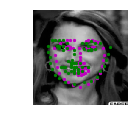

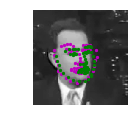

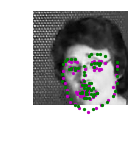

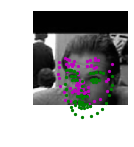

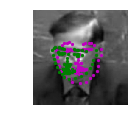

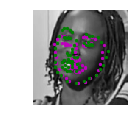

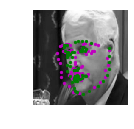

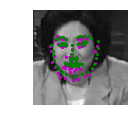

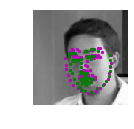

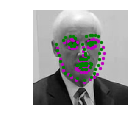

In [32]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [34]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I tried a few and found one that worked

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started out with one covolutional layer and added more layers to improve accuracy. I used a dropout layer to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.07693114 -0.03799754  0.08040076  0.04770454 -0.15673535]
 [-0.15075426  0.03974834 -0.03994096 -0.13204113  0.0153334 ]
 [ 0.15145668 -0.08449368  0.14479734 -0.14521824 -0.16486746]
 [-0.18019114  0.01963847 -0.13191226  0.08506554 -0.16083582]
 [-0.06930967 -0.11263325  0.0690665  -0.06679903 -0.04686923]]
(5, 5)


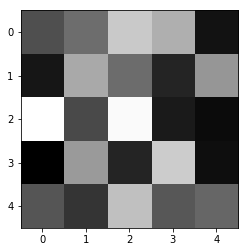

In [39]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 31

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [37]:
##TODO: load in and display any image from the transformed test dataset

image = test_images[0].data   # get the image from it's Variable wrapper
print(image.numpy().size)
#image = image.numpy()   # convert to numpy array from a Tensor
#image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
#plt.imshow(np.squeeze(image)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


50176


In [47]:
print(test_images[0].data.size)

<built-in method size of Tensor object at 0x11d5b1a20>


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!